In [23]:
import tensorflow as tf
import numpy as np
import os
import shutil
from pathlib import Path
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
def merge_folders_advanced(source_parent, destination, conflict_strategy="rename"):
    """
    Merge folders with multiple conflict resolution strategies.
    
    conflict_strategy options:
    - "rename": Append source folder name (default)
    - "overwrite": Replace existing files
    - "skip": Keep existing files
    - "timestamp": Append timestamp
    """
    
    source_parent = Path(source_parent)
    destination = Path(destination)
    destination.mkdir(parents=True, exist_ok=True)
    
    source_folders = [f for f in source_parent.iterdir() if f.is_dir()]
    files_processed = 0
    conflicts_resolved = 0
    
    for source_folder in source_folders:
        for root, dirs, files in os.walk(source_folder):
            root_path = Path(root)
            relative_path = root_path.relative_to(source_folder)
            dest_dir = destination / relative_path
            dest_dir.mkdir(parents=True, exist_ok=True)
            
            for file in files:
                source_file = root_path / file
                dest_file = dest_dir / file
                files_processed += 1
                
                if dest_file.exists():
                    conflicts_resolved += 1
                    
                    if conflict_strategy == "overwrite":
                        pass
                    elif conflict_strategy == "skip":
                        continue
                    elif conflict_strategy == "timestamp":
                        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                        stem, suffix = dest_file.stem, dest_file.suffix
                        dest_file = dest_dir / f"{stem}_{timestamp}{suffix}"
                    else:
                        stem, suffix = dest_file.stem, dest_file.suffix
                        dest_file = dest_dir / f"{stem}_{source_folder.name}{suffix}"
                
                shutil.copy2(source_file, dest_file)
    
    print(f"Merge completed!")
    print(f"Folders processed: {len(source_folders)}")
    print(f"Files processed: {files_processed}")
    print(f"Conflicts resolved: {conflicts_resolved}")



In [18]:
merge_folders_advanced("group_dataset/", "mnist_extend/")

Merge completed!
Folders processed: 10
Files processed: 4796
Conflicts resolved: 4546


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

custom_data = tf.keras.utils.image_dataset_from_directory(
    "mnist_extend/", 
    shuffle=True,
    batch_size=None,
    color_mode='grayscale',
    image_size=(28, 28)
)

custom_images = []
custom_labels = []

for img, label in custom_data:
    custom_images.append(img.numpy())
    custom_labels.append(label.numpy())

custom_images = np.array(custom_images) / 255.0
custom_labels = np.array(custom_labels)

def combine_datasets(x_train, y_train, x_test, y_test,
                     custom_images, custom_labels,
                     train_ratio=0.8):
    """
    train_ratio: proportion of custom dataset that goes into train set
    """
    idx = np.arange(len(custom_images))
    np.random.shuffle(idx)
    custom_images = custom_images[idx]
    custom_labels = custom_labels[idx]

    split = int(len(custom_images) * train_ratio)
    custom_train_x, custom_test_x = custom_images[:split], custom_images[split:]
    custom_train_y, custom_test_y = custom_labels[:split], custom_labels[split:]

    x_train_combined = np.concatenate([x_train, custom_train_x], axis=0)
    y_train_combined = np.concatenate([y_train, custom_train_y], axis=0)

    x_test_combined = np.concatenate([x_test, custom_test_x], axis=0)
    y_test_combined = np.concatenate([y_test, custom_test_y], axis=0)

    train_idx = np.arange(len(x_train_combined))
    np.random.shuffle(train_idx)
    x_train_combined, y_train_combined = x_train_combined[train_idx], y_train_combined[train_idx]

    test_idx = np.arange(len(x_test_combined))
    np.random.shuffle(test_idx)
    x_test_combined, y_test_combined = x_test_combined[test_idx], y_test_combined[test_idx]

    return (x_train_combined, y_train_combined), (x_test_combined, y_test_combined)


(train_x, train_y), (test_x, test_y) = combine_datasets(
    x_train, y_train, x_test, y_test,
    custom_images, custom_labels,
    train_ratio=0.7
)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

Found 9235 files belonging to 10 classes.
(66464, 28, 28, 1) (66464,)
(12771, 28, 28, 1) (12771,)


In [20]:
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),   
    Dense(128, activation='relu'),  
    Dense(64, activation='relu'),    
    Dense(10, activation='softmax') 
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=5, batch_size=128, validation_split=0.1)

test_loss, test_acc = model.evaluate(test_x, test_y)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8519 - loss: 0.4936 - val_accuracy: 0.9099 - val_loss: 0.2951
Epoch 2/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9215 - loss: 0.2514 - val_accuracy: 0.9334 - val_loss: 0.2110
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9389 - loss: 0.1934 - val_accuracy: 0.9433 - val_loss: 0.1822
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9492 - loss: 0.1611 - val_accuracy: 0.9488 - val_loss: 0.1630
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9557 - loss: 0.1379 - val_accuracy: 0.9499 - val_loss: 0.1555
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9101 - loss: 0.2648
Test accuracy: 0.9101


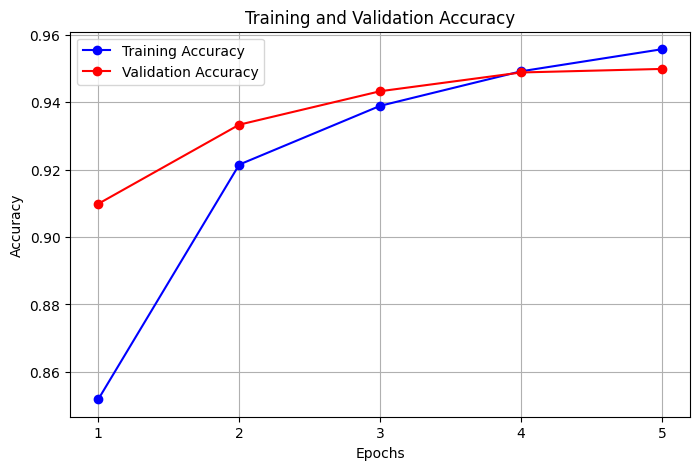

In [21]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


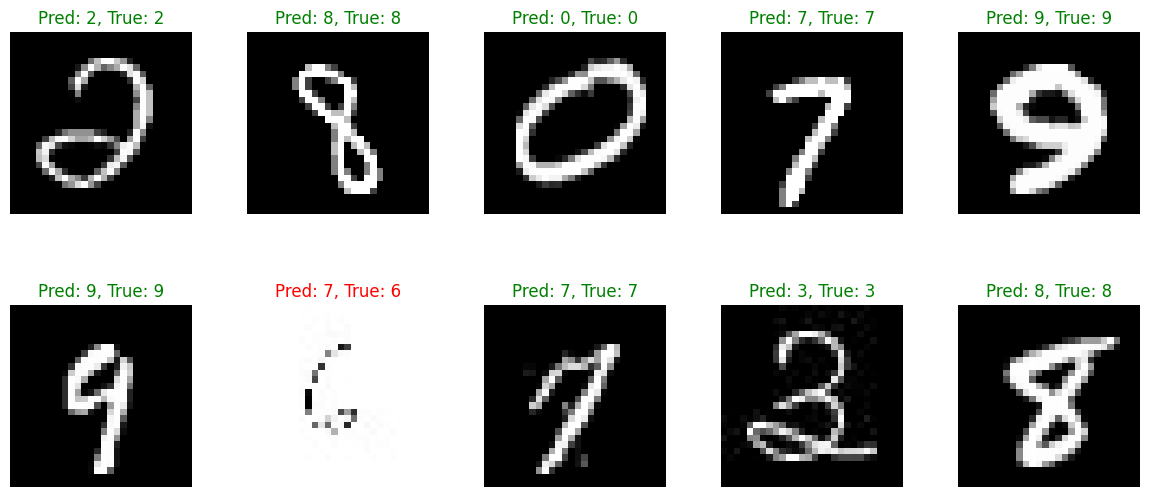

In [24]:
predictions = model.predict(test_x)

random_idxs = np.random.choice(len(test_x), size=10, replace=False)

plt.figure(figsize=(12, 5))
for i, idx in enumerate(random_idxs):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_x[idx].reshape(28, 28), cmap="gray")

    pred_label = np.argmax(predictions[idx])
    true_label = test_y[idx]

    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label}, True: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.subplots_adjust(hspace=0.5) 
plt.show()